In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
from datetime import timedelta
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.collections import PatchCollection

In [2]:
START_OF_DAY = pd.Timestamp('2022-01-02 00:00:00', tz='Europe/Berlin')
END_OF_DAY = pd.Timestamp('2022-01-03 00:00:00', tz='Europe/Berlin')
EXECUTION_TIME_START = (START_OF_DAY - timedelta(days=1)).replace(hour=16, minute=0)
EXECUTION_TIME_END = START_OF_DAY.replace(hour=22, minute=54, second=59)

BUCKET_SIZE = 15
C_RATE = 0.5
RTO = 0.86
MAX_CYCLES = 365
MIN_TRADES = 1

PASSWORD = "123"

In [3]:
password_for_url = f":{PASSWORD}"
CONNECTION = f"postgres://leloq{password_for_url}@127.0.0.1/intradaydb"
CONNECTION_ALCHEMY = f"postgresql://leloq{password_for_url}@127.0.0.1/intradaydb"
conn = psycopg2.connect(CONNECTION)
conn_alchemy = create_engine(CONNECTION_ALCHEMY)
cursor = conn.cursor()
cursor.execute("ROLLBACK")

In [7]:
def derive_soc_from_trades(trade_df: pd.DataFrame, efficiency: float, start_of_day, end_of_day):
    trade_df = trade_df.copy()
    trade_df['product'] = pd.to_datetime(trade_df['product'])
    grouped_by_product = trade_df.groupby('product')

    per_product_data = {}
    
    for idx, product_df in grouped_by_product:
        if product_df.empty:
            continue
        product = product_df['product'].iloc[0]
        sells = product_df[product_df['side'] == 'sell']
        sell_volume = sells['quantity'].sum()
        buys = product_df[product_df['side'] == 'buy']
        buy_volume = buys['quantity'].sum()
    
        net_position = (-1)*sell_volume + buy_volume
    
        vwap_sell = (sells['quantity'] * sells['price']).sum() / sells['quantity'].sum()
        vwap_buy = (buys['quantity'] * buys['price']).sum() / buys['quantity'].sum()
    
        pnl = buy_volume * (-1)*vwap_buy + sell_volume * vwap_sell
    
        net_charge = 0
        net_discharge = 0
        if net_position > 0:
            net_charge = net_position * efficiency
        else:
            net_discharge = (-1)*net_position * (1 / efficiency)
    
        per_product_data.update(
            {product: {'sell_volume': sell_volume, 'buy_volume': buy_volume, 'net_position': net_position,
                       'net_discharge': net_discharge, 'net_charge': net_charge,
                       'vwap_sell': vwap_sell, 'vwap_buy': vwap_buy, 'pnl': pnl}})
    
    per_product_data_df = pd.DataFrame.from_dict(per_product_data).T
    per_product_data_df = per_product_data_df.reindex(pd.date_range(start_of_day, end_of_day-timedelta(minutes=60), freq='60min'), fill_value=0.0)
    per_product_data_df['soc'] = (per_product_data_df['net_charge'] + (-1)*per_product_data_df['net_discharge']).cumsum()
    return per_product_data_df


def get_all_trades():
    print(f'Execution time start: {EXECUTION_TIME_START} \n'
          f'Execution time end: {EXECUTION_TIME_END} \n'
          f'Delivery start : {START_OF_DAY} \n'
          f'Delivery end : {END_OF_DAY} \n')

    cursor.execute(f"""
        SELECT 
        *
        FROM 
        transactions_intraday_de
        WHERE 
        (executiontime BETWEEN '{EXECUTION_TIME_START}' AND '{EXECUTION_TIME_END}')
        AND (product ='XBID_Hour_Power' or product = 'Intraday_Hour_Power')  AND deliverystart < '{END_OF_DAY}' AND deliverystart >= '{START_OF_DAY}'
         AND side = 'BUY'
        """)
    
    result = cursor.fetchall()
    df = pd.DataFrame(result, columns=['idx', 'executiontime', 'deliverystart', 'deliveryend', 'price', 'volume', 'side', 'tradeid'])
    df[["price", "volume"]] = df[["price", "volume"]].astype(float)
    return df


def get_ri_trades():
    path = os.path.join(
            "output",
            "hourly",
            "bs"
            + str(BUCKET_SIZE)
            + "cr"
            + str(C_RATE)
            + "rto"
            + str(RTO)
            + "mc"
            + str(MAX_CYCLES)
            + "mt"
            + str(MIN_TRADES)
        )
    
    trade_path = os.path.join(path, "trades", "trades_" + START_OF_DAY.date().isoformat() + ".csv")
    trades_rib = pd.read_csv(trade_path, index_col=0, parse_dates=True, header=0)
    trades_rib.reset_index(inplace=True)
    return trades_rib


def derive_plotting_data():
    products = pd.date_range(start=START_OF_DAY, end=END_OF_DAY, freq="h")
    buckets = pd.date_range(start=EXECUTION_TIME_START, end=EXECUTION_TIME_END, freq="15min")
    plotting_prices = pd.DataFrame(index=products, columns=buckets.astype(str))
    plotting_sides = pd.DataFrame(index=products, columns=buckets.astype(str))
    
    for idx, (_, df) in enumerate(trades_by_product):
        product = pd.to_datetime(df.deliverystart.values[0]).tz_localize("UTC").tz_convert('Europe/Berlin').isoformat().replace('T', ' ')
        df.sort_values(by='executiontime', inplace=True)
        try:
            trades = trades_rib_by_product.get_group(product)
        except KeyError:
            continue
            
        trades.copy().sort_values(by='execution_time', inplace=True)
            
        for idx, row in trades.iterrows():
            product = pd.to_datetime(trades['product'], utc=True)
            plotting_prices.loc[product.iloc[0], str(row["execution_time"])] = row["price"]
            plotting_sides.loc[product.iloc[0], str(row["execution_time"])] = row["side"]
    
    
    plotting_prices.index = pd.to_datetime(plotting_prices.index, utc=True)
    plotting_sides.index = pd.to_datetime(plotting_sides.index, utc=True)
    plotting_prices.columns = pd.to_datetime(plotting_prices.columns, utc=True)
    plotting_sides.columns = pd.to_datetime(plotting_sides.columns, utc=True)
    plotting_prices.sort_index(axis=1, inplace=True)
    plotting_sides.sort_index(axis=1, inplace=True)
    plotting_prices = plotting_prices.reindex(pd.date_range(START_OF_DAY, END_OF_DAY-timedelta(hours=1), freq='60min'), axis=0)
    plotting_sides = plotting_sides.reindex(pd.date_range(START_OF_DAY, END_OF_DAY-timedelta(hours=1), freq='60min'), axis=0)
    plotting_prices = plotting_prices.reindex(pd.date_range(EXECUTION_TIME_START, EXECUTION_TIME_END+timedelta(hours=1), freq='15min'), axis=1)
    plotting_sides = plotting_sides.reindex(pd.date_range(EXECUTION_TIME_START, EXECUTION_TIME_END+timedelta(hours=1), freq='15min'), axis=1)
        
    plotting_prices_backup = plotting_prices.copy()
    
    plotting_prices.reset_index(inplace=True, drop=True)
    plotting_prices.index = plotting_prices.index
    
    plotting_sides.reset_index(inplace=True, drop=True)
    plotting_sides.index = plotting_sides.index
    
    plotting_sides.columns = np.arange(len(plotting_prices.columns))
    plotting_prices.columns = np.arange(len(plotting_prices.columns))
    
    background = pd.DataFrame(index=np.arange(0, len(plotting_prices.index), 1), data=np.ones(plotting_prices.shape))
    background.columns = pd.to_datetime(plotting_prices_backup.columns, utc=True).tz_convert("Europe/Berlin")
    
    
    prices_and_sides = {}
    prices = []
    for row_idx, row in plotting_prices.iterrows():
        for col_idx, val in row.items():
            if not np.isnan(val):
                prices_and_sides.update({(row_idx, col_idx): {"price":val,
                                                              "side":plotting_sides.loc[row_idx, col_idx]}})
                prices.append(val)

    return plotting_prices, plotting_sides, background, prices, plotting_prices_backup, prices_and_sides

In [8]:
df = get_all_trades()
df['searchkey'] = list(zip(df['deliverystart'], df['deliveryend']))
trades_by_product = df.groupby('searchkey')
trades_rib = get_ri_trades()
trades_rib.round(2).head()
per_product_data = derive_soc_from_trades(trades_rib, 0.86**0.5, START_OF_DAY, END_OF_DAY)
products = pd.to_datetime(trades_rib['product'].unique()).sort_values()
trades_rib_by_product = trades_rib.groupby('product')

plotting_prices, plotting_sides, background, prices, plotting_prices_backup, prices_and_sides = derive_plotting_data()

Execution time start: 2022-01-01 16:00:00+01:00 
Execution time end: 2022-01-02 22:54:59+01:00 
Delivery start : 2022-01-02 00:00:00+01:00 
Delivery end : 2022-01-03 00:00:00+01:00 



## Create Final Plot


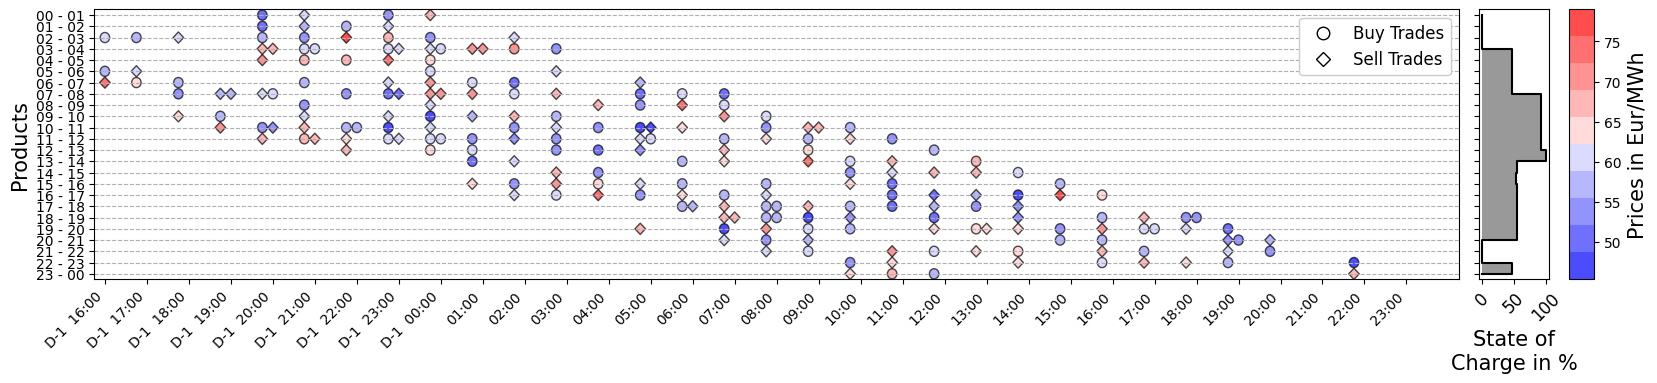

In [15]:
# Plot heatmap
figure = plt.figure(figsize=(15, 2.7))
ax1 = figure.add_subplot(1, 100, (1,91))
ax2 = figure.add_subplot(1, 100, (93,97), sharey=ax1)
ax3 = figure.add_subplot(1, 100, (99,100))

bg=ax1
ax1.set_ylim([-0.5, background.shape[0]-1+0.5])
ax1.grid(axis="y", linestyle='dashed', zorder=2.5)
ax1.set_ylabel('Products', fontsize=15)
ax1.set_xticks(np.arange(0, len(background.columns), 1)[::4], [x.time().strftime("%H:%M") if x > START_OF_DAY else "D-1  " + x.time().strftime("%H:%M") for x in background.columns][::4], rotation=45, ha="right")
ax1.set_yticks(background.index, [f"{x.time().strftime("%H")} - {(x + timedelta(hours=1)).time().strftime("%H")}" for x in plotting_prices_backup.index])
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_xlim([-1, background.shape[1]+1])

patches = []
for key in prices_and_sides:
    if prices_and_sides[key]["side"] == "buy":
        circ = Circle((key[1],key[0]),0.45, edgecolor="black", zorder=10)
        patches.append(circ)
    else:
        poly = RegularPolygon(xy=(key[1],key[0]), numVertices=4, radius=0.5, color="black", zorder=10)
        patches.append(poly)

colors = prices

num_buckets = 10

color_steps = ['#0000ff', '#3333ff', '#6666ff', '#9999ff', '#ccccff', '#ffcccc', '#ff9999', '#ff6666', '#ff3333', '#ff0000']

cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', color_steps, N=num_buckets)

p = PatchCollection(patches, cmap=cmap, alpha=0.7, edgecolors="black")
p.set_array(colors)
ax1.add_collection(p)
ax1.invert_yaxis()

ax2.step(per_product_data["soc"]*100, background.index, color="black")
ax2.fill_between(per_product_data["soc"]*100, background.index, step="pre", alpha=0.4, facecolor="black")

ax2.set_xlabel("State of\nCharge in %", fontsize=15)
ax2.set_xticks(np.arange(0, 101, 50), np.arange(0, 101, 50), rotation=45)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.yaxis.set_tick_params(labelleft=False)

plt.subplots_adjust(left=0.0,
                    bottom=0.0, 
                    right=1, 
                    top=1, 
                    wspace=0.0, 
                    hspace=0.0)

cbar = figure.colorbar(p, cax=ax3)
ax3.set_ylabel('Prices in Eur/MWh', fontsize=15)
figure.subplots_adjust(wspace=0.5)

buy_trade_marker = mlines.Line2D([], [], markeredgecolor='black', markerfacecolor='white', marker='o', linestyle='None',
                          markersize=9, label='Buy Trades')
sell_trade_marker = mlines.Line2D([], [], markeredgecolor='black', markerfacecolor='white', marker='D', linestyle='None',
                          markersize=7, label='Sell Trades')

ax1.legend(handles=[buy_trade_marker, sell_trade_marker], loc='upper right', fontsize=12, framealpha=1)

output_dir = os.path.join("output", "plots")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

figure.savefig(os.path.join(output_dir, f"rolling_intrinsic_{START_OF_DAY.date().isoformat()}_hourly.png"), dpi=300, bbox_inches="tight")